In [1]:
import numpy as np
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 1. Create Data

In [4]:
# create data

nPerClust = 200

# Theta angle
th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

blur = 3

# Generate data : Total instances = 200*2 = 400
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*blur ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]

b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np  )

## 2. Visualization

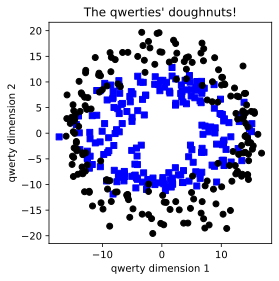

In [5]:
# show the data
fig = plt.figure(figsize=(4,4) ,dpi = 130)

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')

plt.title("The qwerties' doughnuts!")

plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')

plt.show()

## 3. Separate the data into DataLoaders

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [7]:
# scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
#int(train_data.tensors[0].shape[0]/4) -- Hard-coding is better to avoid huge batches!
batchsize    = 16 
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) 

## 4. Create the model class

In [8]:
class theModelClass(nn.Module):
    
    def __init__(self, dropoutRate):
        super().__init__()

        ### layers
        self.input  = nn.Linear(2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128, 1)

        # parameters
        self.dr = dropoutRate

    # forward pass
    def forward(self,x):

        # Pass the data through the input layer
        x = F.relu( self.input(x) )

        # dropout after input layer
        # training=self.training means to turn off during eval mode
        x = F.dropout(x, p = self.dr, training = self.training) 

        # pass the data through the hidden layer
        x = F.relu( self.hidden(x) )

        # dropout after hidden layer
        # training=self.training means to turn off during eval mode
        x = F.dropout( x ,p=self.dr, training=self.training) 

        # output layer
        x = self.output(x)
        # no dropout here!!
        
        return x

In [9]:
# test the model
tmpnet = theModelClass(dropoutRate = .25)

# run some random data through
tmpdata = torch.randn((10,2))

yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.1152],
        [ 0.1042],
        [ 0.0102],
        [-0.0360],
        [-0.1021],
        [ 0.0869],
        [-0.0217],
        [ 0.0050],
        [-0.1613],
        [ 0.0109]], grad_fn=<AddmmBackward0>)

## 5. Functions to create the model , LossFunc and Optimizer

In [10]:
def createANewModel(dropoutrate , LR):

    # grab an instance of the model class
    ANNQC = theModelClass(dropoutrate)

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(),lr=LR)

    return ANNQC,lossfunc,optimizer

## 6. Custom Model training function

In [11]:
numepochs = 1000

def trainTheModel(Model,lossfunc,optimizer, train_loader ,test_loader, epochs ):

    # initialize accuracies as empties (not storing losses here)
    trainAcc = []
    testAcc  = []


  # loop over epochs
    for epochi in range(epochs):

        # switch training mode on 
        Model.train() 

        # loop over training data batches
        batchAcc = []
        
        for X,y in train_loader:

            # forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean(((yHat_train>0)==y).float()).item() )
        
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # test accuracy
        Model.eval()    # switch training off
        
        X,y = next(iter(test_loader))  # extract X,y from test dataloader
        
        yHat_test = Model(X)
        
        testAcc.append( 100*torch.mean(((yHat_test>0)==y).float()).item() )
  
    # function output
    return trainAcc,testAcc

## 7. Model Training and Testing

In [16]:
dropoutrate = 0
LR = 0.01
num_epochs = 1000

ANNQC,lossfunc,optimizer = createANewModel(dropoutrate , LR)

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(Model = ANNQC,
                                lossfunc = lossfunc,
                                optimizer = optimizer ,
                                train_loader = train_loader,
                                test_loader = test_loader,
                                epochs = num_epochs)   

## 8. Data Visualization

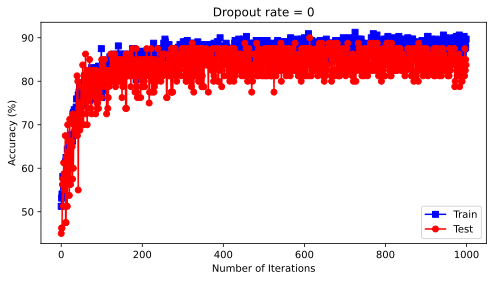

In [17]:
fig = plt.figure(figsize=(8,4) , dpi = 130 )

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')

plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy (%)')

plt.legend(['Train','Test'])

plt.title(f'Dropout rate = {dropoutrate}')

plt.show()

## 9. Experiment

In [14]:
LR = 0.01
num_epochs = 1000

dropoutRates = np.arange(10)/10

results = np.zeros((len(dropoutRates),2))

i = 0
for p in dropoutRates:

    ANNQC,lossfunc,optimizer = createANewModel(dropoutrate = p , LR= LR)

    # train the model (note the inputs!)
    trainAcc,testAcc = trainTheModel(Model = ANNQC,
                                    lossfunc = lossfunc,
                                    optimizer = optimizer ,
                                    train_loader = train_loader,
                                    test_loader = test_loader,
                                    epochs = num_epochs) 
    
    # store accuracies from last 100 epochs
    results[i,0] = np.mean(trainAcc[-100:])
    results[i,1] = np.mean(testAcc[-100:])
    i += 1

## 10. Visualization

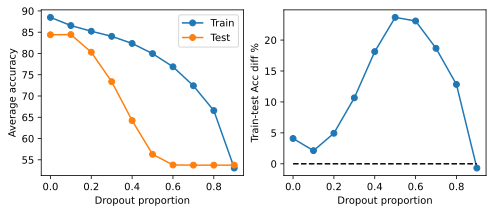

In [15]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test Acc diff %')

plt.show()